In [2]:
import fastf1
import fastf1.plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Enable FastF1 cache (create a folder named 'cache' in your working directory)
fastf1.Cache.enable_cache('cache') 
fastf1.plotting.setup_mpl()

In [3]:
def get_clean_laps(year, gp, session_type, driver):
    session = fastf1.get_session(year, gp, session_type)
    session.load()
    
    # Pick specific driver
    laps = session.laps.pick_driver(driver)
    
    # Filter for quick laps (exclude pit in/out, yellow flags)
    # 'pick_quicklaps' is a helper to remove slow outliers
    clean_laps = laps.pick_quicklaps()
    
    # Reset index to ensure accurate sequential calculations
    clean_laps = clean_laps.reset_index(drop=True)
    
    return clean_laps, session.event['EventName']

# Example: Max Verstappen at 2023 Spanish GP (High Deg Track)
laps, event_name = get_clean_laps(2023, 'Spanish Grand Prix', 'R', 'VER')

core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

In [4]:
def calculate_tyre_degradation(laps, fuel_correction_factor=0.06):
    """
    Models tyre degradation by correcting for fuel burn.
    
    Args:
        laps (pd.DataFrame): Cleaned lap data.
        fuel_correction_factor (float): Time gained per lap due to fuel burn (seconds).
                                        0.06 is a standard approximation for modern F1.
    """
    
    # Convert LapTime to seconds for calculation
    laps['LapTimeSec'] = laps['LapTime'].dt.total_seconds()
    
    # 1. Fuel Correction
    # We ADD time back to later laps to simulate a constant fuel load.
    # Formula: Corrected = Actual + (LapNumber * FuelFactor)
    # This cancels out the ~0.06s gain per lap, leaving only the tyre wear trend.
    laps['FuelCorrectedTime'] = laps['LapTimeSec'] + (laps['LapNumber'] * fuel_correction_factor)
    
    model_results = {}
    
    # Analyze by Stint and Compound
    for stint_id in laps['Stint'].unique():
        stint_data = laps[laps['Stint'] == stint_id]
        compound = stint_data['Compound'].iloc[0]
        
        # We need reasonably long stints to model degradation (e.g., > 3 laps)
        if len(stint_data) > 3:
            # Linear Regression: X = TyreAge, Y = FuelCorrectedTime
            X = stint_data['TyreLife'].values.reshape(-1, 1)
            y = stint_data['FuelCorrectedTime'].values
            
            reg = LinearRegression().fit(X, y)
            deg_per_lap = reg.coef_[0]  # Slope of the line
            intercept = reg.intercept_
            
            # Save results
            model_results[stint_id] = {
                'compound': compound,
                'deg_per_lap': deg_per_lap,
                'data': stint_data,
                'model': reg
            }
            
            print(f"Stint {stint_id} ({compound}): Deg = {deg_per_lap:.3f} s/lap")
            
    return model_results

# Run the calculation
deg_model = calculate_tyre_degradation(laps)

Stint 1.0 (MEDIUM): Deg = 0.041 s/lap
Stint 2.0 (HARD): Deg = 0.065 s/lap
Stint 3.0 (SOFT): Deg = 0.098 s/lap


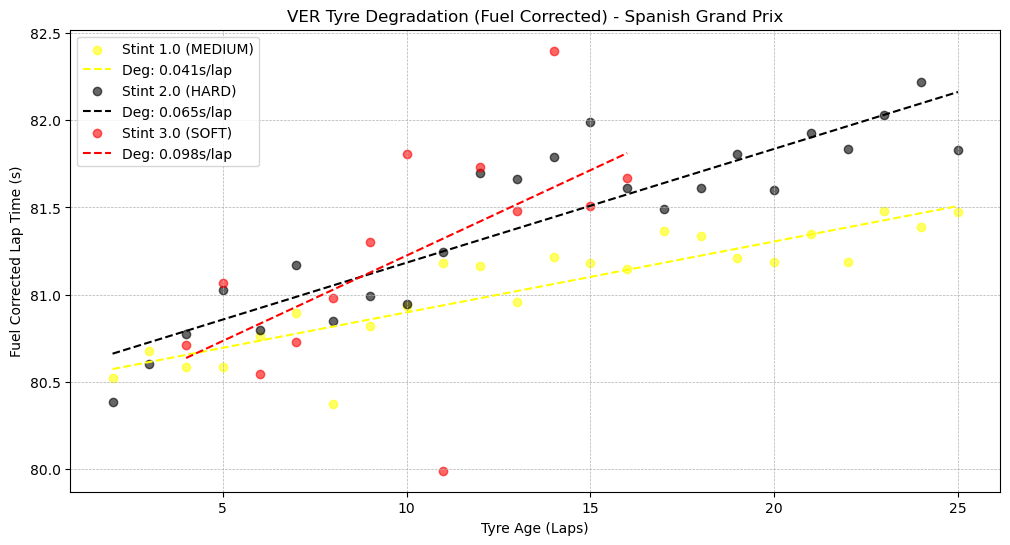

In [6]:
def plot_degradation(deg_model, driver, event_name):
    plt.figure(figsize=(12, 6))
    
    for stint_id, result in deg_model.items():
        data = result['data']
        compound = result['compound']
        deg = result['deg_per_lap']
        
        # Color mapping for compounds
        color_map = {'SOFT': 'red', 'MEDIUM': 'yellow', 'HARD': 'black'}
        c = color_map.get(compound, 'grey')
        
        # Plot Fuel Corrected Data Points
        plt.scatter(data['TyreLife'], data['FuelCorrectedTime'], 
                    color=c, label=f'Stint {stint_id} ({compound})', alpha=0.6)
        
        # Plot Regression Line
        X_pred = data['TyreLife'].values.reshape(-1, 1)
        y_pred = result['model'].predict(X_pred)
        plt.plot(data['TyreLife'], y_pred, color=c, linestyle='--', 
                 label=f'Deg: {deg:.3f}s/lap')
        
    plt.title(f'{driver} Tyre Degradation (Fuel Corrected) - {event_name}')
    plt.xlabel('Tyre Age (Laps)')
    plt.ylabel('Fuel Corrected Lap Time (s)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_degradation(deg_model, 'VER', event_name)